In [33]:
import numpy as np
from utility import get_random_matrices, get_random_matrices_any_size, get_random_matrix_pair_any_size, get_AI_matrices, pad_matrix, unpad_matrix
from matrix_mult import binet, strassen
import time
import matplotlib.pyplot as plt

Klasa dziedzicząca po float i przładowująca operacje zmiennoprzecinkowe, dodając licznik przy ich każdorazowym wywołaniu.

In [4]:
class FloatCounter(float):  

    mul_counter = 0
    add_counter = 0
    sub_counter = 0
    div_counter = 0

    def __new__(cls, value):
        return super().__new__(cls, value)

    def __mul__(self, other):
        FloatCounter.mul_counter += 1
        return FloatCounter(super().__mul__(other))

    def __rmul__(self, value):
        FloatCounter.mul_counter += 1
        return FloatCounter(super().__rmul__(value))

    def __add__(self, value):
        FloatCounter.add_counter += 1
        return FloatCounter(super().__add__(value))

    def __radd__(self, value):
        FloatCounter.add_counter += 1
        return FloatCounter(super().__radd__(value))

    def __sub__(self, value):
        FloatCounter.sub_counter += 1
        return FloatCounter(super().__sub__(value))

    def __rsub__(self, value):
        FloatCounter.sub_counter += 1
        return FloatCounter(super().__rsub__(value))

    def __truediv__(self, value):
        FloatCounter.div_counter += 1
        return FloatCounter(super().__truediv__(value))

    def __rtruediv__(self, value):
        FloatCounter.div_counter += 1
        return FloatCounter(super().__rtruediv__(value))

    def reset_counters():
        FloatCounter.mul_counter = 0
        FloatCounter.add_counter = 0
        FloatCounter.sub_counter = 0
        FloatCounter.div_counter = 0

    def descriptive_print():
        print(f'''Multiplications: {FloatCounter.mul_counter},\nAdditions: {FloatCounter.add_counter},\nSubtractions: {FloatCounter.sub_counter},\nDivisions: {FloatCounter.div_counter}\n''')

    def get_data():
        return (FloatCounter.mul_counter, FloatCounter.add_counter, FloatCounter.sub_counter, FloatCounter.div_counter)

Rzutowanie macierzy float'ów na macierz FloatCounter'ów (np.array(A, dtype=FloatCounter) nie działa)

In [5]:
def float_matrix_to_floatcounter_matrix(a):
    b = np.zeros(a.shape, dtype=FloatCounter)

    for i in range(len(a)):
        for j in range(len(a[i])):
            b[i][j] = FloatCounter(a[i][j])
    return b

Test Binet'a dla macierzy o nieparzystym rozmiarze

In [6]:
A, B = get_random_matrix_pair_any_size(3)
print(A)
A = pad_matrix(A)
print(A)
A = unpad_matrix(A, (3,3))
print(A)

[[0.69348471 0.23736381 0.47646924]
 [0.90668754 0.7882757  0.88943232]
 [0.28386899 0.93570914 0.26623629]]
[[0.69348471 0.23736381 0.47646924 0.        ]
 [0.90668754 0.7882757  0.88943232 0.        ]
 [0.28386899 0.93570914 0.26623629 0.        ]
 [0.         0.         0.         0.        ]]
[[0.69348471 0.23736381 0.47646924]
 [0.90668754 0.7882757  0.88943232]
 [0.28386899 0.93570914 0.26623629]]


Test zliczania FLOPS'ów dla algorytmu Binet'a

In [7]:
matrix = get_random_matrices()
matrix[0][0] = float_matrix_to_floatcounter_matrix(matrix[0][0])
matrix[0][1] = float_matrix_to_floatcounter_matrix(matrix[0][1])
FloatCounter.reset_counters()
binet(matrix[0][0], matrix[0][1])
FloatCounter.descriptive_print()
FloatCounter.reset_counters()

Multiplications: 8,
Additions: 4,
Subtractions: 0,
Divisions: 0



Test zliczania FLOPS'ów dla algorytmu Strassen'a

In [48]:
matrix = get_random_matrices()
matrix[0][0] = float_matrix_to_floatcounter_matrix(matrix[0][0])
matrix[0][1] = float_matrix_to_floatcounter_matrix(matrix[0][1])
FloatCounter.reset_counters()
strassen(matrix[0][0], matrix[0][1])
FloatCounter.descriptive_print()
FloatCounter.reset_counters()

Multiplications: 7,
Additions: 12,
Subtractions: 6,
Divisions: 0



Funkcja mierząca liczbę FLOPS'ów dla danego algorytmu

In [35]:
def measure_FLOPS(function, min_n, max_n, filename):
    # Clearing the file
    with open(filename, "w") as file:
        pass

    for i in range(min_n, max_n + 1):

        A, B = get_random_matrix_pair_any_size(i)

        A = pad_matrix(A)
        B = pad_matrix(B)

        A = float_matrix_to_floatcounter_matrix(A)
        B = float_matrix_to_floatcounter_matrix(B)

        FloatCounter.reset_counters()

        function(A, B)

        results = FloatCounter.get_data()

        with open(filename, "a") as file:
            file.write(str(i) + " " + str(results[0]) + " " + str(results[1]) + " " + str(results[2]) + " " + str(results[3]) + "\n")

Funckaj wyświetlająca wykres dla zmierzonej liczby FLOPS'óœ

In [56]:
def show_FLOPS_plot(filename, algorithm_name):
    data = np.loadtxt(filename)

    n = data[:, 0]
    mul = data[:, 1]
    add = data[:, 2]
    sub = data[:, 3]
    div = data[:, 4]

    flops = mul + add + sub + div

    plt.figure(figsize=(10, 6))
    plt.plot(n, flops)

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Liczba FLOPS'ów")
    plt.title(f"Porównanie liczby FLOPS'ów do rozmiarów macierzy dla algorytmu {algorithm_name}")

    plt.show()

Funckja porównująca liczby FLOPS'ów

In [73]:
def show_FLOPS_comparison_plot(filename1, filename2, algorithm_name_1, algorithm_name_2):
    data1 = np.loadtxt(filename1)

    n1 = data1[:, 0]
    mul1 = data1[:, 1]
    add1 = data1[:, 2]
    sub1 = data1[:, 3]
    div1 = data1[:, 4]

    data2 = np.loadtxt(filename2)

    n2 = data2[:, 0]
    mul2 = data2[:, 1]
    add2 = data2[:, 2]
    sub2 = data2[:, 3]
    div2 = data2[:, 4]


    flops1 = mul1 + add1 + sub1 + div1
    flops2 = mul2 + add2 + sub2 + div2

    plt.figure(figsize=(10, 6))
    plt.plot(n1, flops1, label=algorithm_name_1)
    plt.plot(n1, flops2, label=algorithm_name_2)

    plt.legend()

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Liczba FLOPS'ów")
    plt.title(f"Porównanie liczby FLOPS'ów do rozmiarów macierzy")

    plt.show()

Zliczanie FLOPS'ów dla algorytmu Binet'a

In [44]:
measure_FLOPS(binet, 1, 20, "binet_flops.txt")

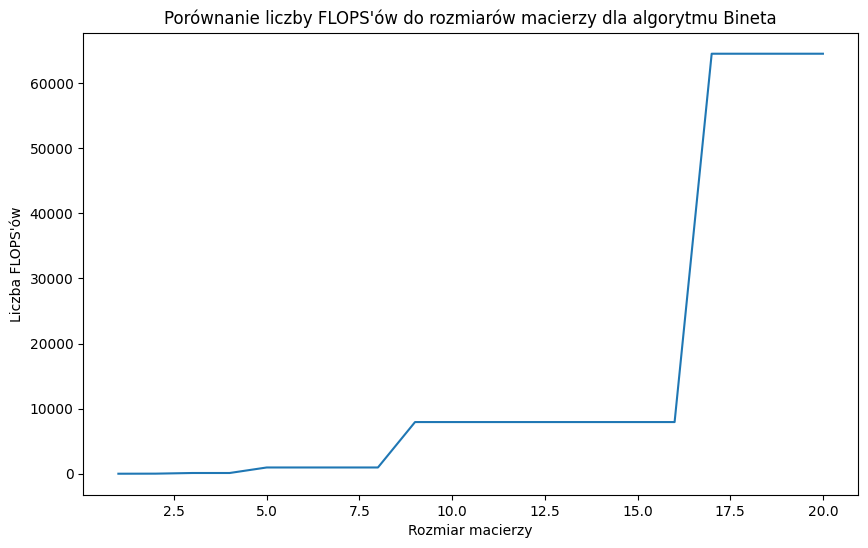

In [57]:
show_FLOPS_plot("binet_flops.txt", "Bineta")

Zliczanie liczby FLOPS'ów dla algorytmu Strassena

In [46]:
measure_FLOPS(strassen, 1, 20, "strassen_flops.txt")

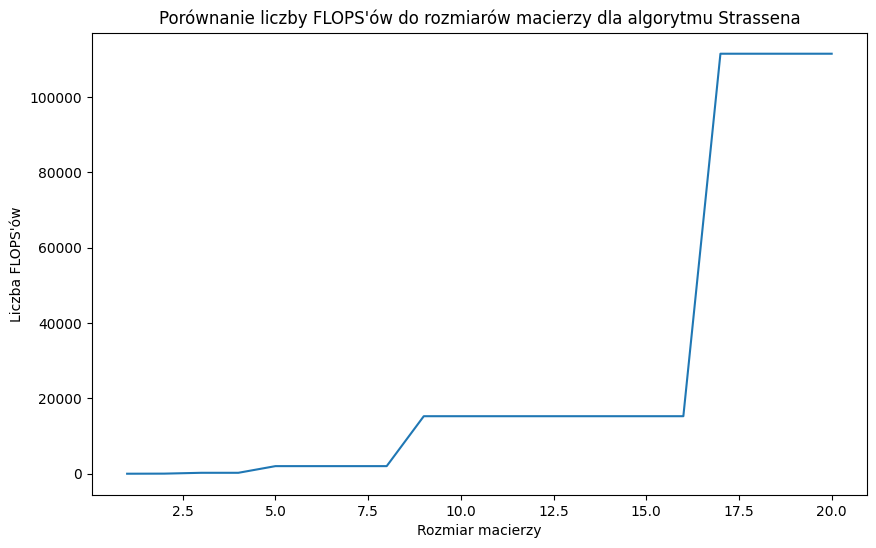

In [58]:
show_FLOPS_plot("strassen_flops.txt", "Strassena")

Porównanie liczby FLOPS'ów między Binetem, a Strassenem

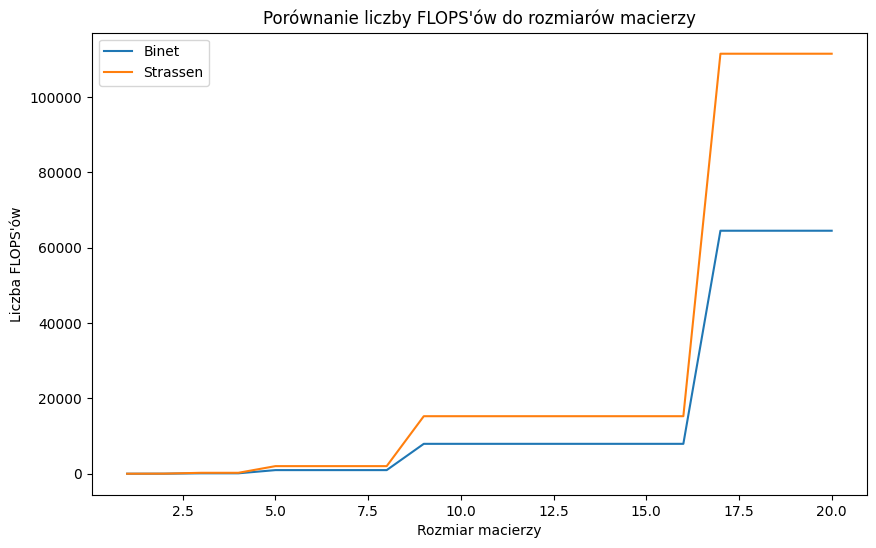

In [74]:
show_FLOPS_comparison_plot("binet_flops.txt", "strassen_flops.txt", "Binet", "Strassen")

Funkcja mierząca czasy wykonania dla danego algorytmu

In [76]:
def measure_function_runtime(function, min_n, max_n, filename):
    # Clearing the file
    with open(filename, "w") as file:
        pass

    for i in range(min_n, max_n + 1):

        A, B = get_random_matrix_pair_any_size(i)

        A = pad_matrix(A)
        B = pad_matrix(B)

        start = time.time()

        function(A, B)

        end = time.time()

        with open(filename, "a") as file:
            file.write(str(i) + " " + str(end - start) + "\n")

Funkcja rysująca wykres czasów wykonania

In [85]:
def show_runtime_plot(filename, algorithm_name):
    data = np.loadtxt(filename)

    n = data[:, 0]
    runtime = data[:, 1]

    plt.figure(figsize=(10, 6))
    plt.plot(n, runtime)

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Czas wykonania")
    plt.title(f"Porównanie liczby FLOPS'ów do rozmiarów macierzy dla algorytmu {algorithm_name}")

    plt.show()

Funkcja porównująca czasy wykonania

In [86]:
def show_runtime_comparison_plot(filename1, filename2, algorithm_name1, algorithm_name2):
    data1 = np.loadtxt(filename1)

    n1 = data1[:, 0]
    runtime1 = data1[:, 1]

    data2 = np.loadtxt(filename2)
    n2 = data2[:, 0]
    runtime2 = data2[:, 1]

    plt.figure(figsize=(10, 6))
    plt.plot(n1, runtime1, label = algorithm_name1)
    plt.plot(n2, runtime2, label = algorithm_name2)

    plt.legend()

    plt.xlabel("Rozmiar macierzy")
    plt.ylabel("Czas wykonania")
    plt.title(f"Porównanie liczby FLOPS'ów do rozmiarów macierzy")

    plt.show()

Mierzenie czasów wykonania dla algorytmu Bineta

In [80]:
measure_function_runtime(binet, 1, 20, "binet_runtime.txt")

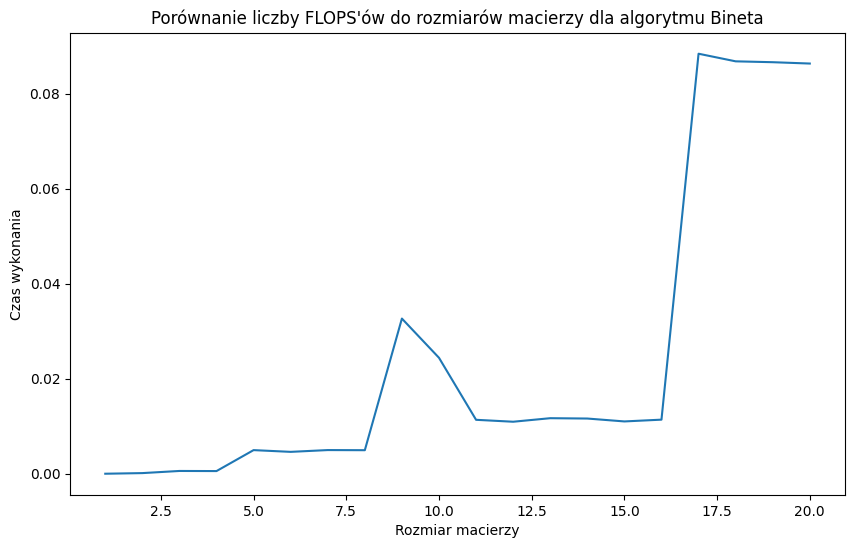

In [81]:
show_runtime_plot("binet_runtime.txt", "Bineta")

Mierzenie czasów wykonania dla algorytmu Strassena

In [82]:
measure_function_runtime(strassen, 1, 20, "strassen_runtime.txt")

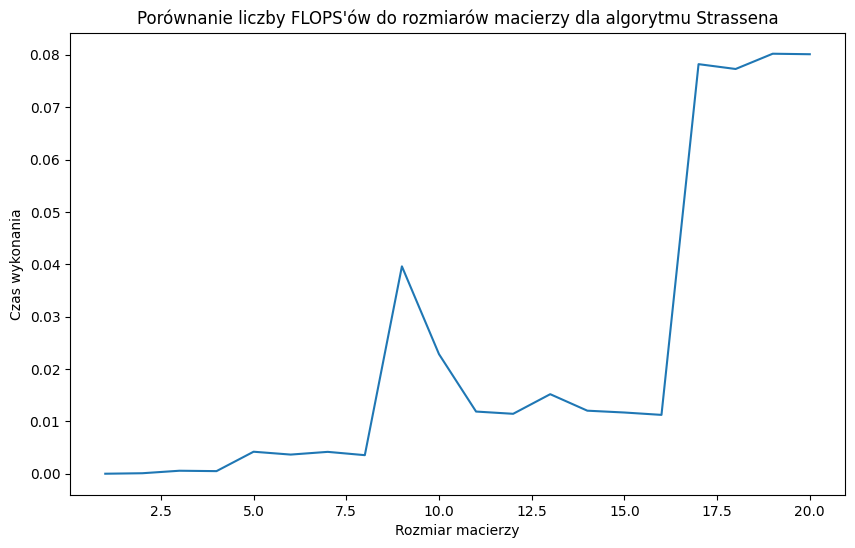

In [83]:
show_runtime_plot("strassen_runtime.txt", "Strassena")

Porównanie czasów wykonania dla obu algorytmów

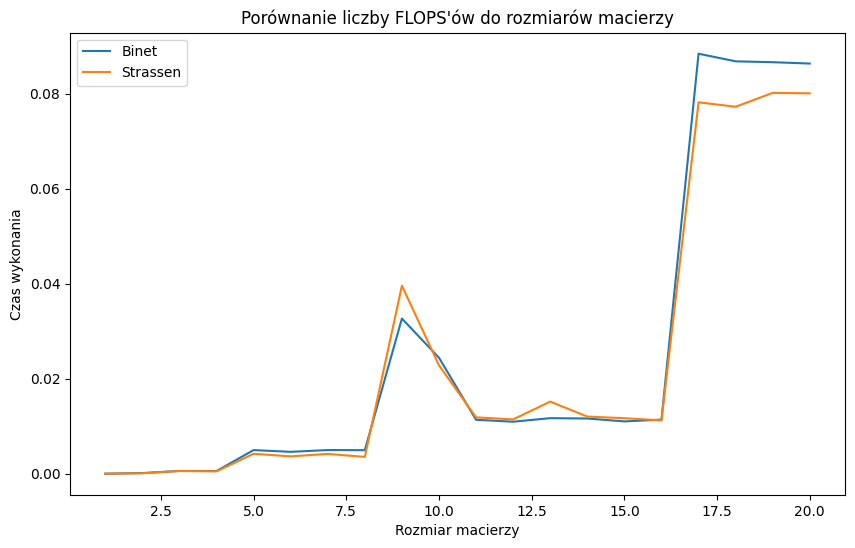

In [89]:
show_runtime_comparison_plot("binet_runtime.txt", "strassen_runtime.txt", "Binet", "Strassen")